In [1]:
import polars as pl

from cstbioinfo.immune.utils import get_oas

# Download a example dataset from OAS
url1 = "https://opig.stats.ox.ac.uk/webapps/ngsdb/paired/Alsoiussi_2020/csv/SRR11528761_paired.csv.gz"
df1 = get_oas(url1)


url2 = "https://opig.stats.ox.ac.uk/webapps/ngsdb/paired/Alsoiussi_2020/csv/SRR11528762_paired.csv.gz"
df2 = get_oas(url2)

In [2]:
from cstbioinfo.immune import clone_overlap, ruzicka_similarity

df1 = df1.with_columns(pl.lit("SRR11528761").alias("sample_id"))
df2 = df2.with_columns(pl.lit("SRR11528762").alias("sample_id"))
df_combined = pl.concat([df1, df2], how="vertical")

print(f"Combined DataFrame shape: {df_combined.shape}")

Combined DataFrame shape: (11388, 195)


In [3]:
df_count = df_combined.group_by(
    ["sample_id", "v_call_heavy", "j_call_heavy", "junction_aa_heavy"]
).agg(pl.len().alias("count"))
df_count.head(2)

sample_id,v_call_heavy,j_call_heavy,junction_aa_heavy,count
str,str,str,str,u32
"""SRR11528762""","""IGHV1-26*01""","""IGHJ3*01""","""CARDYGSSSPWFAYW""",1
"""SRR11528761""","""IGHV13-2*01""","""IGHJ4*01""","""CSRGGLYYDYDGCAMDYW""",4


In [4]:
ruzicka_similarity(
    df_count,
    feature_columns=["v_call_heavy", "j_call_heavy", "junction_aa_heavy"],
    count_column="count",
    sample_column="sample_id",
)

Calculating Ruzicka similarity: 100%|██████████| 1/1 [00:00<00:00, 142.93it/s]


sample_1,sample_2,similarity
str,str,f64
"""SRR11528761""","""SRR11528761""",1.0
"""SRR11528762""","""SRR11528762""",1.0
"""SRR11528761""","""SRR11528762""",0.905622
"""SRR11528762""","""SRR11528761""",0.905622


In [5]:
clone_overlap(
    df_count,
    feature_columns=["v_call_heavy", "j_call_heavy", "junction_aa_heavy"],
    count_column="count",
    sample_column="sample_id",
    fraction=False,
)

Calculating overlap coefficient: 4it [00:00, 685.85it/s]              


sample_1,sample_2,overlap
str,str,i64
"""SRR11528761""","""SRR11528761""",926
"""SRR11528761""","""SRR11528762""",859
"""SRR11528762""","""SRR11528761""",859
"""SRR11528762""","""SRR11528762""",895


## Bigger test with a larger dataset



In [6]:
from tqdm import tqdm

urls = open("./data/Bashford_2013.txt").read().splitlines()

dfs = [get_oas(url) for url in tqdm(urls)]

100%|██████████| 69/69 [00:26<00:00,  2.64it/s]


In [7]:
bashford_df = pl.concat(dfs, how="vertical")
print(f"Bashford DataFrame shape: {bashford_df.shape}")

Bashford DataFrame shape: (258164, 112)


In [8]:
df_count = bashford_df.group_by(["Run", "v_call", "j_call", "junction_aa"]).agg(
    pl.len().alias("count")
)
df_count.head(2)

Run,v_call,j_call,junction_aa,count
str,str,str,str,u32
"""ERR220445""","""IGHV1-8*01""","""IGHJ4*02""","""CASPSYW""",1
"""ERR220446""","""IGHV3-74*01""","""IGHJ5*02""","""CAKSCGDGCYGHGSW""",1


In [9]:
bashford_similarity = ruzicka_similarity(
    df_count,
    feature_columns=["v_call", "j_call", "junction_aa"],
    count_column="count",
    sample_column="Run",
    top_n=1000,
)

Calculating Ruzicka similarity: 100%|██████████| 2346/2346 [00:40<00:00, 58.19it/s] 


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..


/scicore/home/proebste/saary0000/software/custombioinfotools/.venv/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:1769: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/scicore/home/proebste/saary0000/software/custombioinfotools/.venv/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/scicore/home/proebste/saary0000/software/custombioinfotools/.venv/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/scicore/home/proebste/saary0000/software/custombioinfotools/.v

Starting plotting HeatmapAnnotations
Plotting legends..
Incresing ncol


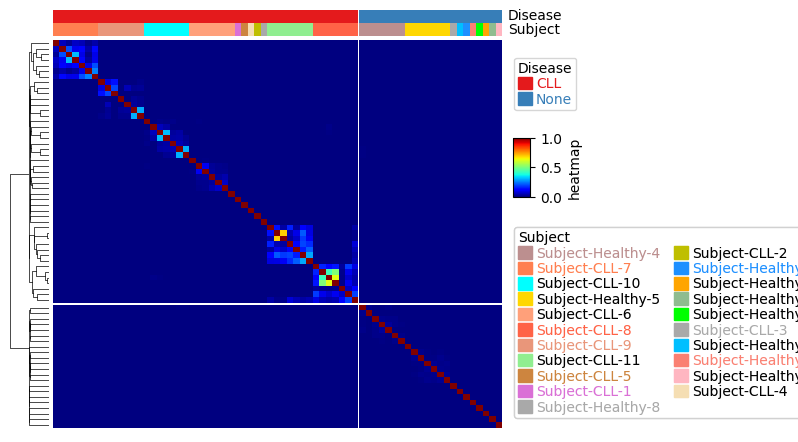

In [10]:
import PyComplexHeatmap as pch

metadata = bashford_df.select(["Disease", "Subject", "Run"]).unique().to_pandas()
metadata.set_index("Run", inplace=True)

column_annotation = pch.HeatmapAnnotation(df=metadata)

similarity_matrix = (
    bashford_similarity.pivot(index=["sample_1"], on="sample_2", values="similarity")
    .fill_null(0)
    .to_pandas()
)
similarity_matrix = similarity_matrix.set_index("sample_1")

cm = pch.ClusterMapPlotter(
    data=similarity_matrix,
    top_annotation=column_annotation,
    row_dendrogram=True,
    legend_width=70,
    col_split=metadata["Disease"],
    row_split=metadata["Disease"],
)

In [11]:
# overlap instead of similarity
overlapping_clones = clone_overlap(
    df_count,
    feature_columns=["v_call", "j_call", "junction_aa"],
    count_column="count",
    sample_column="Run",
    fraction=True,
)

Calculating overlap coefficient: 4761it [00:23, 199.99it/s]                          


Starting plotting..
Starting calculating row orders..
Reordering rows..


/scicore/home/proebste/saary0000/software/custombioinfotools/.venv/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:1769: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/scicore/home/proebste/saary0000/software/custombioinfotools/.venv/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/scicore/home/proebste/saary0000/software/custombioinfotools/.venv/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/scicore/home/proebste/saary0000/software/custombioinfotools/.v

Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Incresing ncol


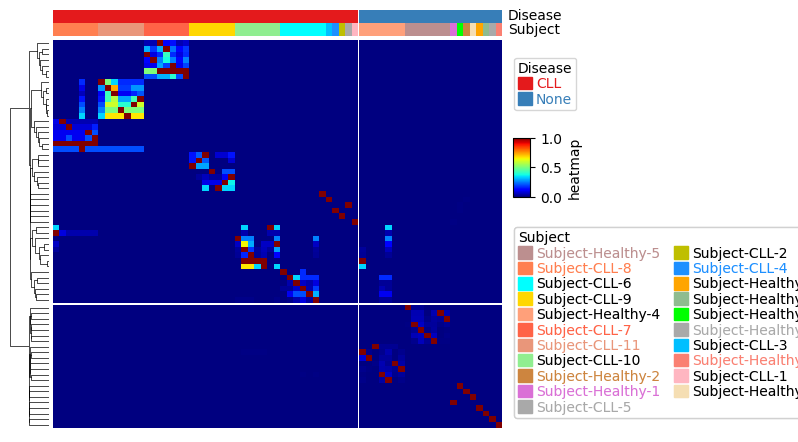

In [12]:
metadata = bashford_df.select(["Disease", "Subject", "Run"]).unique().to_pandas()
metadata.set_index("Run", inplace=True)

column_annotation = pch.HeatmapAnnotation(df=metadata)

similarity_matrix = (
    overlapping_clones.pivot(index=["sample_1"], on="sample_2", values="overlap")
    .fill_null(0)
    .to_pandas()
)
similarity_matrix = similarity_matrix.set_index("sample_1")

cm = pch.ClusterMapPlotter(
    data=similarity_matrix,
    top_annotation=column_annotation,
    row_dendrogram=True,
    legend_width=70,
    col_split=metadata["Disease"],
    row_split=metadata["Disease"],
)